### Importing the Required Libraries 

In [19]:
#Imoorting the required libraries
import numpy as np 
import pandas as pd
from numpy import count_nonzero
#from scipy.sparse import csr_matrix
from feature_selector import FeatureSelector

### Creating the sparse dataset

In [20]:
# generate random matrix
num_rows = 1000
num_cols = 10
np.random.seed(seed=100)
mat = np.random.rand(num_rows, num_cols)

# make row and col labels
rows = range(num_rows)
cols = range(num_cols)
rows = [str(i) for i in rows]
cols = [str(i) for i in cols]

# make dataframe 
df = pd.DataFrame(data=mat, columns=cols, index=rows)


In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.543405,0.278369,0.424518,0.844776,0.004719,0.121569,0.670749,0.825853,0.136707,0.575093
1,0.891322,0.209202,0.185328,0.108377,0.219697,0.978624,0.811683,0.171941,0.816225,0.274074
2,0.431704,0.940030,0.817649,0.336112,0.175410,0.372832,0.005689,0.252426,0.795663,0.015255
3,0.598843,0.603805,0.105148,0.381943,0.036476,0.890412,0.980921,0.059942,0.890546,0.576901
4,0.742480,0.630184,0.581842,0.020439,0.210027,0.544685,0.769115,0.250695,0.285896,0.852395


In [22]:
#Making the df sparse and checking the density
df[df < 0.9] = 0
sdf = df.to_sparse(fill_value = 0)
sdf.density

0.1015

In [23]:
print(sdf.shape)
sdf.head()

(1000, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.978624,0.000000,0.0,0.0,0.0
2,0.0,0.94003,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.000000,0.980921,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [24]:
#Checking the count of zeroes per column
count = 0
for x in range(1000):
    if(sdf['9'][x] == 0):
        count = count + 1
print(count)

899


In [6]:
#Storing the sparse dataframe
sdf.to_csv("C:\\Users\\Aman.aggarwal\\Documents\\Exelon\\Chem Sampling\\Regression models\\data1.csv", index = False)

In [25]:
#REading the stored dataframe
df = pd.read_csv("C:\\Users\\Aman.aggarwal\\Documents\\Exelon\\Chem Sampling\\Regression models\\data1.csv")

In [26]:
#Replacing zeroes in dataframe with nan
#sdf = sdf.replace({'0':np.nan, 0:np.nan})
df.replace(0, np.nan, inplace=True)

In [27]:
#Checking the dataframe
print(df.shape)
df.head()

(1000, 10)


,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0.978624,NaN,NaN,NaN,NaN
2,NaN,0.94003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.980921,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating target variable column 

In [28]:
##Creating the target variable
# generate random matrix
num_rows = 1000
num_cols = 1
np.random.seed(seed=100)
mat = np.random.rand(num_rows, num_cols)

# make row and col labels
rows = range(num_rows)
cols = range(num_cols)
rows = [str(i) for i in rows]
cols = [str(i) for i in cols]

# make dataframe 
target = pd.DataFrame(data=mat, columns=cols, index=rows)
target.shape

(1000, 1)

In [29]:
#Checking the count of zeroes per column
count = 0
for x in range(1000):
    if(target['0'][x] == 0):
        count = count + 1
print(count)

0


### Creating instance for feature selector class 

In [30]:
# Creating instance
fs = FeatureSelector(data = df, labels = target)

#### Missing Value check 

In [31]:
# Checking the missing values, threshold 
fs.identify_missing(missing_threshold = 0.8)

10 features with greater than 0.80 missing values.



In [32]:
fs.missing_stats.head()

,missing_fraction
0,0.921
6,0.906
8,0.904
7,0.902
1,0.900


In [33]:
missing_features = fs.ops['missing']
missing_features[:5]

['0', '1', '2', '3', '4']

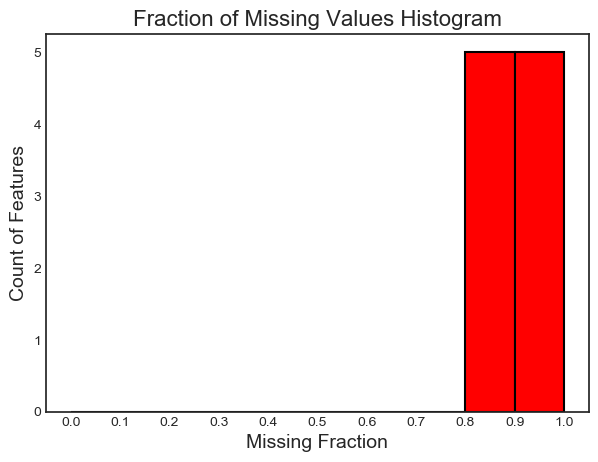

In [34]:
fs.plot_missing()

#### Singularity & Uniqueness check 

In [35]:
# Check if there is any singular column
fs.identify_single_unique()
single_unique = fs.ops['single_unique']
single_unique

0 features with a single unique value.



[]

In [36]:
# Getting the count of unique values in a column
fs.unique_stats.sample(5)

,nunique
2,105
3,125
5,107
7,98
9,101


#### Zero Importance features from gbm 

In [37]:
# Using lgbm as it will ignore missing values during a split, 
#then allocate them to whichever side reduces the loss the most
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'mae', 
                            n_iterations = 10, 
                            early_stopping = False)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.



#### Cumulative feature importance from gbm 

In [38]:
# this will retain only the most important features needed to 
# reach specified cumulative_importance of the total feature importance
fs.identify_low_importance(cumulative_importance = 0.99)

9 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.



In [39]:
fs.feature_importances

,feature,importance,normalized_importance,cumulative_importance
0,3,2932.0,0.125567,0.125567
1,5,2666.0,0.114176,0.239743
2,2,2582.0,0.110578,0.350321
3,4,2535.0,0.108565,0.458887
4,1,2267.0,0.097088,0.555974
5,9,2205.0,0.094433,0.650407
6,7,2125.0,0.091006,0.741413
7,6,2114.0,0.090535,0.831949
8,8,2067.0,0.088522,0.920471
9,0,1857.0,0.079529,1.000000


#### Collinear Features

In [40]:
fs.identify_collinear(correlation_threshold=0.975)

correlated_features = fs.ops['collinear']
correlated_features[:5]

0 features with a correlation magnitude greater than 0.97.



[]

### Github link 
* https://github.com/WillKoehrsen/feature-selector/blob/master/Feature%20Selector%20Usage.ipynb
* https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py